# Note about model comparison scoring: 
### many of the r^2 scores that were previously done in the notebook were cross validations done with the training set. This isn't quite as helpful to use as a score metric to compare the models. I recalculated the r^2 value using the testing set of each of the models using the same testing set in order to make more accurate comparisons. 

For all models (except the linear 2 feature one):
training: X8   and  y_train
testing: X_test8  and y_test

For the 2 feature model:
training: X2  and y_train
testing: X_test2  and y_test


#### Data Pre-Processing Stage 

## Import Statements 

In [79]:
#display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix

#imported this to get rid of warning 
import pandas.util.testing as tm

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm


from datetime import datetime

## format the hourly df to use datetime 

In [80]:
#read df
df = pd.read_csv('/Users/isaiahhollars/newProjects/NashvilleWeatherHourly.csv',low_memory=False )

#display more columns
pd.set_option('display.max_columns', None)

#trim down columns 
df = df[['DATE','HourlyDewPointTemperature','HourlyDryBulbTemperature', 'HourlyPrecipitation','HourlyPressureChange','HourlyRelativeHumidity','HourlyVisibility','HourlyWetBulbTemperature','HourlyWindDirection','HourlyWindSpeed','HourlyWindGustSpeed']]

df.shape

(125902, 11)

In [81]:
#change to datetime index and throw out the extra T

format = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['DATE'].str.replace('T',' '), format=format)



#drop the old date and just use the Datetime index 
df = df.drop(['DATE'], axis=1)


## Convert columns to strings to fix issues and then convert them to floats

In [82]:
#For PressureChange
df['HourlyPressureChange'] = df['HourlyPressureChange'].str.replace('+','')

df['HourlyPressureChange'] = df['HourlyPressureChange'].str.replace('s','')

df['HourlyPressureChange'] = df['HourlyPressureChange'].astype(float)



#for DewPoint
#convert to string, fix errors with strings, convert back to float

df['HourlyDewPointTemperature']= df['HourlyDewPointTemperature'].astype(str).str.replace("s", "")

df['HourlyDewPointTemperature'] = df['HourlyDewPointTemperature'].astype(float)

#For DryBulbTemp
#convert to string, fix errors with strings, convert back to float

df['HourlyDryBulbTemperature']= df['HourlyDryBulbTemperature'].astype(str).str.replace("s", "")

df['HourlyDryBulbTemperature'] = df['HourlyDryBulbTemperature'].astype(float)

#For Precip
#convert to string, fix errors with strings, convert back to float

df['HourlyPrecipitation']= df['HourlyPrecipitation'].astype(str).str.replace("T", "0")
df['HourlyPrecipitation']= df['HourlyPrecipitation'].astype(str).str.replace("s", "")
df['HourlyPrecipitation']= df['HourlyPrecipitation'].astype(str).str.replace("0.050.0", "0.05")



df['HourlyPrecipitation'] = df['HourlyPrecipitation'].astype(float)

#For HourlyVisibility
#convert to string, fix errors with strings, convert back to float


df['HourlyVisibility']= df['HourlyVisibility'].astype(str).str.replace("V", "")
df['HourlyVisibility']= df['HourlyVisibility'].astype(str).str.replace("s", "")


df['HourlyVisibility'] = df['HourlyVisibility'].astype(float)

#For WindDirection
#convert to string, fix errors with strings, convert back to float

df['HourlyWindDirection']= df['HourlyWindDirection'].astype(str).str.replace("VRB", "Nan")



df['HourlyWindDirection'] = df['HourlyWindDirection'].astype(float)

df.dtypes
df.isnull().sum()

HourlyDewPointTemperature           float64
HourlyDryBulbTemperature            float64
HourlyPrecipitation                 float64
HourlyPressureChange                float64
HourlyRelativeHumidity              float64
HourlyVisibility                    float64
HourlyWetBulbTemperature            float64
HourlyWindDirection                 float64
HourlyWindSpeed                     float64
HourlyWindGustSpeed                 float64
Datetime                     datetime64[ns]
dtype: object

HourlyDewPointTemperature      3408
HourlyDryBulbTemperature       3402
HourlyPrecipitation           40110
HourlyPressureChange          74011
HourlyRelativeHumidity         3408
HourlyVisibility               3396
HourlyWetBulbTemperature       3716
HourlyWindDirection            8377
HourlyWindSpeed                3635
HourlyWindGustSpeed          113677
Datetime                          0
dtype: int64

## Convert the hourly df to a daily df by max, min,mean,and sum

In [83]:
dfmax = df.resample('d', on='Datetime').max()   #.dropna(how='all')

dfmin = df.resample('d', on='Datetime').min()     #.dropna(how='all')

dfmean = df.resample('d', on='Datetime').mean()     #.dropna(how='all')

dfsum = df.resample('d', on='Datetime').sum()      #.dropna(how='all')

In [84]:
#make one big daily df out of min,max,mean,sum daily frames

dfdaily = pd.concat([dfmin['HourlyDewPointTemperature'], dfmax['HourlyDewPointTemperature'],dfmean['HourlyDewPointTemperature']
                     ,dfmin['HourlyDryBulbTemperature'], dfmax['HourlyDryBulbTemperature'],dfmean['HourlyDryBulbTemperature']
                     ,dfmin['HourlyRelativeHumidity'], dfmax['HourlyRelativeHumidity'],dfmean['HourlyRelativeHumidity']
                     ,dfmin['HourlyVisibility'], dfmax['HourlyVisibility'],dfmean['HourlyVisibility']
                       ,dfmin['HourlyWetBulbTemperature'], dfmax['HourlyWetBulbTemperature'],dfmean['HourlyWetBulbTemperature']
                         ,dfmin['HourlyWindDirection'], dfmax['HourlyWindDirection'],dfmean['HourlyWindDirection']
                           ,dfmin['HourlyWindSpeed'], dfmax['HourlyWindSpeed'],dfmean['HourlyWindSpeed']
                            ,dfsum['HourlyPrecipitation'],dfsum['HourlyPressureChange']], axis=1)


#Change the column names of the daily frame 
newcolnames= ['dewPointMin','dewPointMax','dewPointMean', 'dryBulbMin', 'dryBulbMax', 'dryBulbMean','HumidityMin','HumidityMax','HumidityMean','VisibilityMin','VisibilityMax','VisibilityMean','wetBulbMin','wetBulbMax','wetBulbMean','windDirectionMin','windDirectionMax','windDirectionMean','windSpeedMin','windSpeedMax','windSpeedMean','PrecipitationTotal','PressureChangeTotal']

dfdaily.columns = newcolnames

### dummy variable creation for wind direction (North is left out)

make new dummy variables for the wind direction
normally dummy variable are for categorical data, but in this case 1 degrees and 359 degrees are both almost the name thing so I made 4 categories N,E,S,W

In [85]:
wd = dfdaily['windDirectionMean']

#we can leave out 1 dummy variable because if it's not E,S,or W then it has to be North

#dfdaily['windDirectionOutOfNorth'] = np.where( ((wd>=315)|(wd<45)) , 1 ,0)
dfdaily['windDirectionOutOfEast'] = np.where( ((45<=wd) & (wd<135)) , 1 ,0)
dfdaily['windDirectionOutOfSouth'] = np.where( ((135<=wd) & (wd<225)) , 1 ,0)
dfdaily['windDirectionOutOfWest'] = np.where( ((225<=wd) & (wd<315)) , 1 ,0)



## Make parameters for the previous 3 days 

Make 3 separate dataframes that are shifted down 1, 2 , and 3 days 
Change their column names so that you know they are from prev days.
Lastly, combine into one big df. 

In [86]:
dfdaily1 = dfdaily.shift(periods=1)
dfdaily1.columns += '1'

dfdaily2 = dfdaily.shift(periods=2)
dfdaily2.columns += '2'

dfdaily3 = dfdaily.shift(periods=3)
dfdaily3.columns += '3'


dfdaily = pd.concat([dfdaily,dfdaily1,dfdaily2,dfdaily3], axis=1)


drop the first 3 rows because we don't have previous data on them 

In [87]:
dfdaily = dfdaily.drop(dfdaily.index[0:3])

Drop the old wind Columns 

In [88]:
dfdaily = dfdaily.drop(['windDirectionMin','windDirectionMax','windDirectionMean','windDirectionMin1','windDirectionMax1','windDirectionMean1','windDirectionMin2','windDirectionMax2','windDirectionMean2','windDirectionMin3','windDirectionMax3','windDirectionMean3'],axis=1 )

## Separate the Parameters and the Target Variable

The target variable will be Minimum Temperature !    dryBulbMin (dryBulb measures air temperature)

For the parameters: 
We should not include any of the weather data that is from the current day because that's cheating. We should also not include the target variable. 

dfdaily.head()
dfdaily.shape

In [89]:

#Target Variable
#define it before we get rid of it
y = dfdaily[['dryBulbMin']]




#cols to drop respresent the current days data 
colsToDrop = dfdaily.columns[0:23]    
X = dfdaily.drop(colsToDrop, axis=1)






In [90]:
colsToDrop

Index(['dewPointMin', 'dewPointMax', 'dewPointMean', 'dryBulbMin',
       'dryBulbMax', 'dryBulbMean', 'HumidityMin', 'HumidityMax',
       'HumidityMean', 'VisibilityMin', 'VisibilityMax', 'VisibilityMean',
       'wetBulbMin', 'wetBulbMax', 'wetBulbMean', 'windSpeedMin',
       'windSpeedMax', 'windSpeedMean', 'PrecipitationTotal',
       'PressureChangeTotal', 'windDirectionOutOfEast',
       'windDirectionOutOfSouth', 'windDirectionOutOfWest'],
      dtype='object')

## Train Test Split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=21)

## Feature Scale X_train

This function takes a dataframe and list of columns and it feature scales each column
in the data frame

In [92]:
def scaleColumns(df, colsToScale):
    for col in colsToScale:
        df[col] = (df[col] - (df[col].mean()) ) / (df[col].std())   #z score normalize 
    return df

We don't need to scale the dummy variables because they are already 0 and 1s. 

In [93]:
 #other way : colsToScale = X_train.drop(['windDirectionOutOfEast1','windDirectionOutOfSouth1','windDirectionOutOfWest1','windDirectionOutOfEast2','windDirectionOutOfSouth2','windDirectionOutOfWest2','windDirectionOutOfEast3','windDirectionOutOfSouth3','windDirectionOutOfWest3',],axis=1 )

    
#don't scale the wind dummies
#scale the X_train
notColsToScale = X_train.filter(regex = '^windDirectionOutOf', axis=1)

scaleCols = X_train.drop(notColsToScale,axis=1)

X_train = scaleColumns( X_train , scaleCols)


#now scale the X_test separately...
notColsToScale = X_test.filter(regex = '^windDirectionOutOf', axis=1)
scaleCols = X_test.drop(notColsToScale,axis=1)
X_test = scaleColumns( X_test , scaleCols)


X_train.shape
y_test.shape
X_train.head(1)
X_test.head(1)

/Users/isaiahhollars/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2628, 69)

(657, 1)

dewPointMin1  dewPointMax1  dewPointMean1  dryBulbMin1  \
Datetime                                                             
2011-06-24      1.117009      0.990018       1.091994     1.231842   

            dryBulbMax1  dryBulbMean1  HumidityMin1  HumidityMax1  \
Datetime                                                            
2011-06-24     1.018544      1.058779     -0.129671      0.687514   

            HumidityMean1  VisibilityMin1  VisibilityMax1  VisibilityMean1  \
Datetime                                                                     
2011-06-24       0.349047        0.933824        0.042881         0.595931   

            wetBulbMin1  wetBulbMax1  wetBulbMean1  windSpeedMin1  \
Datetime                                                            
2011-06-24     1.226472      0.93987       1.09666      -0.448677   

            windSpeedMax1  windSpeedMean1  PrecipitationTotal1  \
Datetime                                                         
2011-06-24       0.396568         0.49978            -0.358213   

            PressureChangeTotal1  windDirectionOutOfEast1  \
Datetime                                                    
2011-06-24              0.334764                      0.0   

            windDirectionOutOfSouth1  windDirectionOutOfWest1  dewPointMin2  \
Datetime                                                                      
2011-06-24                       1.0                      0.0      1.226321   

            dewPointMax2  dewPointMean2  dryBulbMin2  dryBulbMax2  \
Datetime                                                            
2011-06-24      1.114681       1.101077     1.056617     0.447036   

            dryBulbMean2  HumidityMin2  HumidityMax2  HumidityMean2  \
Datetime                                                              
2011-06-24      0.690064      1.888527       0.69239       1.443645   

            VisibilityMin2  VisibilityMax2  VisibilityMean2  wetBulbMin2  \
Datetime                                                                   
2011-06-24       -1.284682        0.043396         -0.09437     1.108786   

            wetBulbMax2  wetBulbMean2  windSpeedMin2  windSpeedMax2  \
Datetime                                                              
2011-06-24     0.943054      0.968845       2.487524       0.432899   

            windSpeedMean2  PrecipitationTotal2  PressureChangeTotal2  \
Datetime                                                                
2011-06-24        0.979236            -0.175565              0.098406   

            windDirectionOutOfEast2  windDirectionOutOfSouth2  \
Datetime                                                        
2011-06-24                      0.0                       1.0   

            windDirectionOutOfWest2  dewPointMin3  dewPointMax3  \
Datetime                                                          
2011-06-24                      0.0      1.225731      1.110405   

            dewPointMean3  dryBulbMin3  dryBulbMax3  dryBulbMean3  \
Datetime                                                            
2011-06-24       1.136154     1.050607     0.843508      0.971715   

            HumidityMin3  HumidityMax3  HumidityMean3  VisibilityMin3  \
Datetime                                                                
2011-06-24      0.919953      0.256385        0.62944       -0.801035   

            VisibilityMax3  VisibilityMean3  wetBulbMin3  wetBulbMax3  \
Datetime                                                                
2011-06-24        0.038769         0.319073     1.103487     1.148681   

            wetBulbMean3  windSpeedMin3  windSpeedMax3  windSpeedMean3  \
Datetime                                                                 
2011-06-24      1.098308       2.007133       0.044982        0.854941   

            PrecipitationTotal3  PressureChangeTotal3  \
Datetime                                                
2011-06-24            -0.318425             -0.161819   

   

dewPointMin1  dewPointMax1  dewPointMean1  dryBulbMin1  \
Datetime                                                             
2015-03-12      0.120011      0.216612       0.183868    -0.294038   

            dryBulbMax1  dryBulbMean1  HumidityMin1  HumidityMax1  \
Datetime                                                            
2015-03-12    -0.703438     -0.427646      2.288627      1.306077   

            HumidityMean1  VisibilityMin1  VisibilityMax1  VisibilityMean1  \
Datetime                                                                     
2015-03-12       1.883421       -1.719202        0.067677        -2.971153   

            wetBulbMin1  wetBulbMax1  wetBulbMean1  windSpeedMin1  \
Datetime                                                            
2015-03-12    -0.134869    -0.085234     -0.116952      -0.419957   

            windSpeedMax1  windSpeedMean1  PrecipitationTotal1  \
Datetime                                                         
2015-03-12      -1.036036       -0.510839            -0.009588   

            PressureChangeTotal1  windDirectionOutOfEast1  \
Datetime                                                    
2015-03-12              -1.60682                      0.0   

            windDirectionOutOfSouth1  windDirectionOutOfWest1  dewPointMin2  \
Datetime                                                                      
2015-03-12                       1.0                      0.0       0.32612   

            dewPointMax2  dewPointMean2  dryBulbMin2  dryBulbMax2  \
Datetime                                                            
2015-03-12      0.575565       0.472764    -0.010566    -0.181581   

            dryBulbMean2  HumidityMin2  HumidityMax2  HumidityMean2  \
Datetime                                                              
2015-03-12     -0.122777      2.281474      1.286174       1.947314   

            VisibilityMin2  VisibilityMax2  VisibilityMean2  wetBulbMin2  \
Datetime                                                                   
2015-03-12       -1.076921        0.049371        -0.707079     0.093613   

            wetBulbMax2  wetBulbMean2  windSpeedMin2  windSpeedMax2  \
Datetime                                                              
2015-03-12     0.323273      0.217804      -0.444286       0.379933   

            windSpeedMean2  PrecipitationTotal2  PressureChangeTotal2  \
Datetime                                                                
2015-03-12        0.351878              0.65765              0.154604   

            windDirectionOutOfEast2  windDirectionOutOfSouth2  \
Datetime                                                        
2015-03-12                      0.0                       1.0   

            windDirectionOutOfWest2  dewPointMin3  dewPointMax3  \
Datetime                                                          
2015-03-12                      0.0     -0.057874     -0.163887   

            dewPointMean3  dryBulbMin3  dryBulbMax3  dryBulbMean3  \
Datetime                                                            
2015-03-12      -0.190661     -0.36647    -0.704588     -0.584227   

            HumidityMin3  HumidityMax3  HumidityMean3  VisibilityMin3  \
Datetime                                                                
2015-03-12      0.945865      0.582639       1.023063       -0.131759   

            VisibilityMax3  VisibilityMean3  wetBulbMin3  wetBulbMax3  \
Datetime                                                                
2015-03-12        0.062728         0.467571    -0.265831    -0.514691   

            wetBulbMean3  windSpeedMin3  windSpeedMax3  windSpeedMean3  \
Datetime                                                                 
2015-03-12     -0.399961      -0.423317       -1.20188       -0.772811   

            PrecipitationTotal3  PressureChangeTotal3  \
Datetime                                                
2015-03-12            -0.271447              0.827031   

   

# Now for the Models

First we will use stats models to do linear regression with ordinary least squares 

In [94]:
#We need to put X_train and y_train into a single dataframe if we do smf.ols
combinedXandY = pd.concat([X_train, y_train], axis=1) 
combinedXandY.head()

dewPointMin1  dewPointMax1  dewPointMean1  dryBulbMin1  \
Datetime                                                             
2011-06-24      1.117009      0.990018       1.091994     1.231842   
2012-11-18     -0.819975     -1.226662      -1.022529    -1.211119   
2015-03-26      0.417543      0.127975       0.252219     0.397660   
2012-08-23      0.525153      0.374273       0.488083     0.516829   
2017-02-26     -1.519442     -0.734067      -1.535669    -0.972781   

            dryBulbMax1  dryBulbMean1  HumidityMin1  HumidityMax1  \
Datetime                                                            
2011-06-24     1.018544      1.058779     -0.129671      0.687514   
2012-11-18    -0.640967     -0.980885     -0.844901      0.155104   
2015-03-26     0.274625      0.332260      0.325476     -0.696752   
2012-08-23     1.018544      0.828463     -1.039964      0.581032   
2017-02-26    -0.469293     -0.943151     -1.170006     -3.784731   

            HumidityMean1  VisibilityMin1  VisibilityMax1  VisibilityMean1  \
Datetime                                                                     
2011-06-24       0.349047        0.933824        0.042881         0.595931   
2012-11-18      -0.386479       -0.162666        0.042881         0.316620   
2015-03-26      -0.337034        0.933824        0.042881         0.593391   
2012-08-23      -0.641121        0.933824        0.042881         0.593391   
2017-02-26      -2.107167        0.933824        0.042881         0.593391   

            wetBulbMin1  wetBulbMax1  wetBulbMean1  windSpeedMin1  \
Datetime                                                            
2011-06-24     1.226472     0.939870      1.096660      -0.448677   
2012-11-18    -1.115555    -0.878862     -1.029137      -0.448677   
2015-03-26     0.385745     0.310309      0.285199      -0.448677   
2012-08-23     0.565901     0.590114      0.629138      -0.448677   
2017-02-26    -1.175607    -0.529106     -1.190870       0.986361   

            windSpeedMax1  windSpeedMean1  PrecipitationTotal1  \
Datetime                                                         
2011-06-24       0.396568        0.499780            -0.358213   
2012-11-18      -1.085909       -1.620896            -0.358213   
2015-03-26       1.323116        1.482945            -0.358213   
2012-08-23      -1.085909       -0.998119            -0.358213   
2017-02-26       1.137807        1.462855            -0.358213   

            PressureChangeTotal1  windDirectionOutOfEast1  \
Datetime                                                    
2011-06-24              0.334764                      0.0   
2012-11-18             -0.075476                      0.0   
2015-03-26              0.505697                      0.0   
2012-08-23             -0.143849                      1.0   
2017-02-26             -3.083903                      0.0   

            windDirectionOutOfSouth1  windDirectionOutOfWest1  dewPointMin2  \
Datetime                                                                      
2011-06-24                       1.0                      0.0      1.226321   
2012-11-18                       0.0                      0.0     -0.869389   
2015-03-26                       1.0                      0.0     -0.063347   
2012-08-23                       0.0                      0.0      0.474015   
2017-02-26                       0.0                      1.0     -0.063347   

            dewPointMax2  dewPointMean2  dryBulbMin2  dryBulbMax2  \
Datetime                                                            
2011-06-24      1.114681       1.101077     1.056617     0.447036   
2012-11-18     -1.341000      -1.115352    -1.204903    -0.698450   
2015-03-26     -0.174551      -0.141776    -0.312198     0.275213   
2012-08-23      0.439369       0.401295     0.342453     0.790682   
2017-02-26      0.132409       0.234489     0.640021     0.504310   

            dryBulbMean2  HumidityMin2  HumidityMax2  HumidityMean2  \
Dateti

In [95]:
#all the columns of X_train
X_train.columns[0:69]

Index(['dewPointMin1', 'dewPointMax1', 'dewPointMean1', 'dryBulbMin1',
       'dryBulbMax1', 'dryBulbMean1', 'HumidityMin1', 'HumidityMax1',
       'HumidityMean1', 'VisibilityMin1', 'VisibilityMax1', 'VisibilityMean1',
       'wetBulbMin1', 'wetBulbMax1', 'wetBulbMean1', 'windSpeedMin1',
       'windSpeedMax1', 'windSpeedMean1', 'PrecipitationTotal1',
       'PressureChangeTotal1', 'windDirectionOutOfEast1',
       'windDirectionOutOfSouth1', 'windDirectionOutOfWest1', 'dewPointMin2',
       'dewPointMax2', 'dewPointMean2', 'dryBulbMin2', 'dryBulbMax2',
       'dryBulbMean2', 'HumidityMin2', 'HumidityMax2', 'HumidityMean2',
       'VisibilityMin2', 'VisibilityMax2', 'VisibilityMean2', 'wetBulbMin2',
       'wetBulbMax2', 'wetBulbMean2', 'windSpeedMin2', 'windSpeedMax2',
       'windSpeedMean2', 'PrecipitationTotal2', 'PressureChangeTotal2',
       'windDirectionOutOfEast2', 'windDirectionOutOfSouth2',
       'windDirectionOutOfWest2', 'dewPointMin3', 'dewPointMax3',
       'dewPointMe

## Stats model syntax: 2 different ways to do linear regression
### sm.OLS and smf.ols

There are 2 different ways to go about it 

1. sm.OLS(y,X).fit()    Note: this way you have to use X = sm.add_constant(X) to get intercept 


2. smf.ols("y~x" , data = df)



## We will use backward selection strategy and start with a full model

In [96]:
#all columns at first
X = X_train[X_train.columns[0:69]]

y = y_train['dryBulbMin']

X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dryBulbMin   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     373.9
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:56:03   Log-Likelihood:                -7980.9
No. Observations:                2628   AIC:                         1.610e+04
Df Residuals:                    2558   BIC:                         1.651e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       51.0512      0.854     59.756      0.000      49.376      52.726
dewPointMin1                 8.8047      1.049      8.394      0.000       6.748      10.862
dewPointMax1                 3.6622      0.945      3.876      0.000       1.810       5.515
dewPointMean1              -23.2455      3.624     -6.414      0.000     -30.353     -16.138
dryBulbMin1                 -0.1432      1.614     -0.089      0.929      -3.308       3.021
dryBulbMax1                 -4.1908      1.236     -3.392      0.001      -6.614      -1.768
dryBulbMean1                18.4074      3.740      4.922      0.000      11.075      25.740
HumidityMin1                -0.3274      0.355     -0.923      0.356      -1.023       0.368
HumidityMax1                -0.9631      0.256     -3.758      0.000      -1.466      -0.461
HumidityMean1                3.8645      1.148      3.365      0.001       1.612       6.116
VisibilityMin1               0.0023      0.203      0.011      0.991      -0.395       0.400
VisibilityMax1               0.0030      0.105      0.029      0.977      -0.202       0.208
VisibilityMean1             -0.0031      0.208     -0.015      0.988      -0.411       0.404
wetBulbMin1                  2.4835      2.045      1.215      0.225      -1.526       6.493
wetBulbMax1                  4.8753      1.530      3.187      0.001       1.876       7.875
wetBulbMean1                 6.3435      4.267      1.487      0.137      -2.023      14.710
windSpeedMin1                0.0638      0.147      0.433      0.665      -0.225       0.352
windSpeedMax1               -0.1565      0.195     -0.804      0.422      -0.538       0.225
windSpeedMean1              -1.0085      0.257     -3.922      0.000      -1.513      -0.504
PrecipitationTotal1         -0.4571      0.135     -3.388      0.001      -0.722      -0.193
PressureChangeTotal1         0.5758      0.134      4.294      0.000       0.313       0.839
windDirectionOutOfEast1      1.1096      0.536      2.071      0.038       0.059       2.160
windDirectionOutOfSouth1     0.0815      0.539      0.151      0.880      -0.976       1.139
windDirectionOutOfWest1     -2.2405      0.578     -3.879      0.000      -3.373      -1.108
dewPointMin2                -1.4924      1.081     -1.380      0.168      -3.613       0.628
dewPointMax2                -3.1965      0.989     -3.231      0.001      -5.137      -1.256
dewPointMean2                1.9897      3.844      0.518      0.605      -5.549       9.528
dryBulbMin2                 -1.9009      1.639     -1.160      0.246      -5.115       1.313
dryBulbMax2                 -1.2796      1.228     -1.042      0.298      -3.689       1.129
dryBulbMean2                -4.4707      4.201     -1.064      0.287     -12.708       3.766
HumidityMin2  

### Eliminate the parameters that have a p value greater than alpha 
### Let alpha = 0.05 for now 

### 20 Useful Parameters that are left: 

In [97]:
#Let X only equal the useful parameters now 

X20 = X[['dewPointMin1','dewPointMax1','dewPointMean1','dryBulbMax1','dryBulbMean1',
       'HumidityMax1','HumidityMean1','wetBulbMax1','windSpeedMean1','PrecipitationTotal1',
       'PressureChangeTotal1','windDirectionOutOfWest1',
       'dewPointMax2','VisibilityMax2','PressureChangeTotal2',
       'dewPointMean3','HumidityMean3','VisibilityMax3','wetBulbMin3','PrecipitationTotal3']]
X20.head(1)
X20.shape
       
       

dewPointMin1  dewPointMax1  dewPointMean1  dryBulbMax1  \
Datetime                                                             
2011-06-24      1.117009      0.990018       1.091994     1.018544   

            dryBulbMean1  HumidityMax1  HumidityMean1  wetBulbMax1  \
Datetime                                                             
2011-06-24      1.058779      0.687514       0.349047      0.93987   

            windSpeedMean1  PrecipitationTotal1  PressureChangeTotal1  \
Datetime                                                                
2011-06-24         0.49978            -0.358213              0.334764   

            windDirectionOutOfWest1  dewPointMax2  VisibilityMax2  \
Datetime                                                            
2011-06-24                      0.0      1.114681        0.043396   

            PressureChangeTotal2  dewPointMean3  HumidityMean3  \
Datetime                                                         
2011-06-24              0.098406       1.136154        0.62944   

            VisibilityMax3  wetBulbMin3  PrecipitationTotal3  
Datetime                                                      
2011-06-24        0.038769     1.103487            -0.318425

(2628, 20)

### Run a linear regression model with the new parameters


In [98]:
X20 = sm.add_constant(X20)
model = sm.OLS(y,X20).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dryBulbMin   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     1248.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:56:03   Log-Likelihood:                -8042.7
No. Observations:                2628   AIC:                         1.613e+04
Df Residuals:                    2607   BIC:                         1.625e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      51.6916      0.114    453.217      0.000      51.468      51.915
dewPointMin1                9.7719      0.710     13.757      0.000       8.379      11.165
dewPointMax1                3.1433      0.896      3.508      0.000       1.386       4.900
dewPointMean1             -18.5536      2.694     -6.886      0.000     -23.837     -13.270
dryBulbMax1                -5.4148      0.909     -5.959      0.000      -7.197      -3.633
dryBulbMean1               20.9387      2.297      9.117      0.000      16.435      25.442
HumidityMax1               -0.8635      0.206     -4.183      0.000      -1.268      -0.459
HumidityMean1               2.8291      0.829      3.414      0.001       1.204       4.454
wetBulbMax1                 5.7371      1.210      4.740      0.000       3.364       8.111
windSpeedMean1             -1.3380      0.129    -10.350      0.000      -1.591      -1.084
PrecipitationTotal1        -0.3539      0.121     -2.916      0.004      -0.592      -0.116
PressureChangeTotal1        0.7430      0.127      5.858      0.000       0.494       0.992
windDirectionOutOfWest1    -2.6668      0.338     -7.884      0.000      -3.330      -2.004
dewPointMax2               -2.3407      0.320     -7.321      0.000      -2.968      -1.714
VisibilityMax2             -0.2250      0.103     -2.193      0.028      -0.426      -0.024
PressureChangeTotal2       -0.9464      0.134     -7.087      0.000      -1.208      -0.685
dewPointMean3              -0.4007      0.649     -0.617      0.537      -1.673       0.872
HumidityMean3              -0.4128      0.166     -2.481      0.013      -0.739      -0.087
VisibilityMax3              0.3839      0.103      3.741      0.000       0.183       0.585
wetBulbMin3                 1.9537      0.610      3.204      0.001       0.758       3.150
PrecipitationTotal3         0.2681      0.115      2.338      0.019       0.043       0.493
==============================================================================
Omnibus:                      155.928   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              437.519
Skew:                          -0.298   Prob(JB):                     9.86e-96
Kurtosis:                       4.908   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

dewPointMin3 had a pvalue greater than alpha, so it will be removed from parameters X


In [99]:
#drop the bad predictor 
X19 = X20.drop('dewPointMean3', axis = 1)

Now for another linear regression, hopefully all parameters will have low p-values 

In [100]:
X19 = sm.add_constant(X19)
model = sm.OLS(y,X19).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dryBulbMin   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     1314.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:56:03   Log-Likelihood:                -8042.9
No. Observations:                2628   AIC:                         1.613e+04
Df Residuals:                    2608   BIC:                         1.624e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      51.6925      0.114    453.317      0.000      51.469      51.916
dewPointMin1                9.7607      0.710     13.748      0.000       8.369      11.153
dewPointMax1                3.1226      0.895      3.488      0.000       1.367       4.878
dewPointMean1             -18.5431      2.694     -6.883      0.000     -23.826     -13.260
dryBulbMax1                -5.4260      0.908     -5.974      0.000      -7.207      -3.645
dryBulbMean1               20.9384      2.296      9.118      0.000      16.435      25.442
HumidityMax1               -0.8603      0.206     -4.169      0.000      -1.265      -0.456
HumidityMean1               2.8347      0.828      3.422      0.001       1.210       4.459
wetBulbMax1                 5.7556      1.210      4.757      0.000       3.383       8.128
windSpeedMean1             -1.3385      0.129    -10.355      0.000      -1.592      -1.085
PrecipitationTotal1        -0.3556      0.121     -2.931      0.003      -0.594      -0.118
PressureChangeTotal1        0.7415      0.127      5.848      0.000       0.493       0.990
windDirectionOutOfWest1    -2.6727      0.338     -7.906      0.000      -3.336      -2.010
dewPointMax2               -2.3742      0.315     -7.536      0.000      -2.992      -1.757
VisibilityMax2             -0.2252      0.103     -2.196      0.028      -0.426      -0.024
PressureChangeTotal2       -0.9283      0.130     -7.127      0.000      -1.184      -0.673
HumidityMean3              -0.4777      0.129     -3.704      0.000      -0.731      -0.225
VisibilityMax3              0.3789      0.102      3.704      0.000       0.178       0.580
wetBulbMin3                 1.6226      0.290      5.592      0.000       1.054       2.192
PrecipitationTotal3         0.2653      0.115      2.315      0.021       0.041       0.490
==============================================================================
Omnibus:                      156.018   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.177
Skew:                          -0.298   Prob(JB):                     7.10e-96
Kurtosis:                       4.910   Cond. No.                         97.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
#Here are the correleations for the selected variables 
pd.concat([X19, y], axis=1).corr()

const  dewPointMin1  dewPointMax1  dewPointMean1  \
const                      NaN           NaN           NaN            NaN   
dewPointMin1               NaN      1.000000      0.937542       0.980384   
dewPointMax1               NaN      0.937542      1.000000       0.980044   
dewPointMean1              NaN      0.980384      0.980044       1.000000   
dryBulbMax1                NaN      0.879866      0.886797       0.892954   
dryBulbMean1               NaN      0.931411      0.929909       0.944265   
HumidityMax1               NaN      0.441455      0.481894       0.477704   
HumidityMean1              NaN      0.396710      0.408416       0.425725   
wetBulbMax1                NaN      0.941855      0.975554       0.970854   
windSpeedMean1             NaN     -0.257483     -0.137615      -0.199455   
PrecipitationTotal1        NaN      0.132081      0.194746       0.175082   
PressureChangeTotal1       NaN      0.073405      0.026237       0.062055   
windDirectionOutOfWest1    NaN     -0.282859     -0.204070      -0.250257   
dewPointMax2               NaN      0.859780      0.848512       0.857902   
VisibilityMax2             NaN      0.022566      0.025175       0.022742   
PressureChangeTotal2       NaN      0.151841      0.266157       0.218770   
HumidityMean3              NaN      0.130983      0.083973       0.101673   
VisibilityMax3             NaN      0.023383      0.033811       0.028178   
wetBulbMin3                NaN      0.830919      0.788529       0.813027   
PrecipitationTotal3        NaN     -0.034002     -0.053515      -0.046107   
dryBulbMin                 NaN      0.900826      0.858747       0.888111   

                         dryBulbMax1  dryBulbMean1  HumidityMax1  \
const                            NaN           NaN           NaN   
dewPointMin1                0.879866      0.931411      0.441455   
dewPointMax1                0.886797      0.929909      0.481894   
dewPointMean1               0.892954      0.944265      0.477704   
dryBulbMax1                 1.000000      0.978256      0.235905   
dryBulbMean1                0.978256      1.000000      0.259720   
HumidityMax1                0.235905      0.259720      1.000000   
HumidityMean1               0.018731      0.108116      0.767681   
wetBulbMax1                 0.956637      0.973265      0.377218   
windSpeedMean1             -0.242830     -0.211523     -0.249051   
PrecipitationTotal1         0.020135      0.044588      0.279815   
PressureChangeTotal1        0.092708      0.082545      0.008022   
windDirectionOutOfWest1    -0.282354     -0.269419     -0.112999   
dewPointMax2                0.772888      0.822987      0.403924   
VisibilityMax2              0.036501      0.037556     -0.032845   
PressureChangeTotal2        0.131860      0.157702      0.165204   
HumidityMean3               0.009265      0.021804      0.242568   
VisibilityMax3              0.037132      0.037184      0.003805   
wetBulbMin3                 0.791881      0.824504      0.310849   
PrecipitationTotal3        -0.066912     -0.061775      0.039428   
dryBulbMin                  0.904199      0.929365      0.252816   

                         HumidityMean1  wetBulbMax1  windSpeedMean1  \
const                              NaN          NaN             NaN   
dewPointMin1                  0.396710     0.941855       -0.257483   
dewPointMax1                  0.408416     0.975554       -0.137615   
dewPointMean1                 0.425725     0.970854       -0.199455   
dryBulbMax1                   0.018731     0.956637       -0.242830   
dryBulbMean1                  0.108116     0.973265       -0.211523   
HumidityMax1                  0.767681     0.377218       -0.249051   
HumidityMean1                 1.000000     0.261715       -0.041483   
wetBulbMax1                   0.261715     1.000000       -0.175571   
windSpeedMean1               -0.041483    -0.175571        1.000000   
PrecipitationTotal1           0.432779     0.138377 

### We will remove parameters that have correlation values close to 0 because that means that they don't have a strong linear relationship with dryBulbMin...

### Do Note: These parameters might have other strong non linear relationships with dryBulbMin but linear regression assumes a linear relationship, so we will have to get rid of them for now. 

In [102]:
#no hard feelings 
X8 = X19.drop(['HumidityMax1','HumidityMean1','windSpeedMean1','PrecipitationTotal1','PressureChangeTotal1',
           'windDirectionOutOfWest1','VisibilityMax2','PressureChangeTotal2','HumidityMean3',
           'VisibilityMax3','PrecipitationTotal3'] , axis=1 )
X8.head(1)

const  dewPointMin1  dewPointMax1  dewPointMean1  dryBulbMax1  \
Datetime                                                                    
2011-06-24    1.0      1.117009      0.990018       1.091994     1.018544   

            dryBulbMean1  wetBulbMax1  dewPointMax2  wetBulbMin3  
Datetime                                                          
2011-06-24      1.058779      0.93987      1.114681     1.103487

Now we are left with only 8 parameters...

In [103]:
#another linear regression model...
X8 = sm.add_constant(X8)
model = sm.OLS(y,X8).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dryBulbMin   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     2612.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:56:04   Log-Likelihood:                -8257.8
No. Observations:                2628   AIC:                         1.653e+04
Df Residuals:                    2619   BIC:                         1.659e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            51.2755      0.109    468.342      0.000      51.061      51.490
dewPointMin1     12.3191      0.736     16.734      0.000      10.876      13.763
dewPointMax1      1.2045      0.928      1.298      0.194      -0.615       3.024
dewPointMean1   -10.5879      1.285     -8.238      0.000     -13.108      -8.068
dryBulbMax1      -2.2390      0.832     -2.691      0.007      -3.871      -0.607
dryBulbMean1     14.1561      0.831     17.026      0.000      12.526      15.786
wetBulbMax1       2.3258      1.205      1.930      0.054      -0.037       4.689
dewPointMax2     -3.8757      0.303    -12.774      0.000      -4.471      -3.281
wetBulbMin3       2.3900      0.279      8.571      0.000       1.843       2.937
==============================================================================
Omnibus:                      165.407   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              573.790
Skew:                          -0.237   Prob(JB):                    2.53e-125
Kurtosis:                       5.240   Cond. No.                         38.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Cross Validate the r^2 score: 

In [104]:
sklr = LinearRegression()
X8 = X8.drop('const', axis=1)
y = y_train

crossVal10 = cross_val_score(sklr, X8, y, cv=10)
print("cross validation r^2 scores: ", crossVal10)
print( "average r^2 score: " , crossVal10.mean() )

cross validation r^2 scores:  [0.89028274 0.87485117 0.90055345 0.90560663 0.87024362 0.89485962
 0.8700518  0.85833488 0.90906769 0.89347275]
average r^2 score:  0.8867324346416948


All is well with that. 

## Residuals and Error for training set

Residual Plot: Predictions vs Error/resid

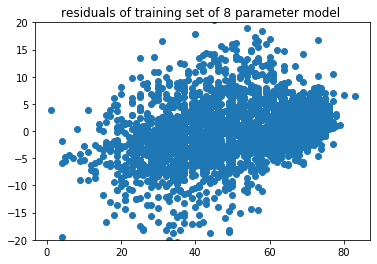

In [105]:
X8 = sm.add_constant(X8)
ypred= model.predict(X8)

residuals = y_train['dryBulbMin'] - ypred

plt.title('residuals of training set of 8 parameter model ');
plt.scatter(y_train['dryBulbMin'], residuals)
plt.ylim(-20,20);

### Try to find Standard Error of model
MSE = SSE/ ( n - (k+1) )   n is sample size  and k is number of beta coef. We have plus 1 becuase of the constant
S = sqrt (MSE)


In [106]:
SSE = sum(residuals**2)
print('SSE: ', SSE)

#MSE = SSE/ ( n - (k+1) )

MSE = (SSE)/( 2628 - (8+1))
print('MSE: ', MSE)

#S = √MSE 
S = (MSE)**(1/2)
print('root MSE: ', S)

SSE:  82499.98328151935
MSE:  31.50056635415019
root MSE:  5.612536534771974


### Standard Error of model 
This means that the average error for the predictions by the model is about 5.6 degrees F. Not too great but not too shabby. 

## Find standard error and residuals for the test set: 

In [107]:
#use the same predictors on X_test except the constant 
goodPredictors = X8.drop('const' , axis = 1 ).columns

X_test8 = X_test[goodPredictors]
X_test8.head(1)
X_test8.shape

dewPointMin1  dewPointMax1  dewPointMean1  dryBulbMax1  \
Datetime                                                             
2015-03-12      0.120011      0.216612       0.183868    -0.703438   

            dryBulbMean1  wetBulbMax1  dewPointMax2  wetBulbMin3  
Datetime                                                          
2015-03-12     -0.427646    -0.085234      0.575565    -0.265831

(657, 8)

Use previous model to predict the X_test8 values 

### Test Residuals:

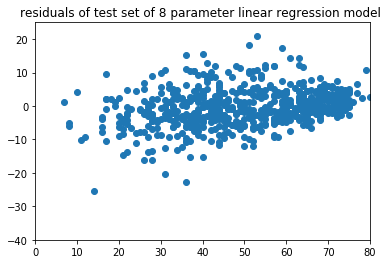

In [108]:
X_test8 = sm.add_constant(X_test8)
ypred = model.predict(X_test8)

residuals = y_test['dryBulbMin'] - ypred

plt.title('residuals of test set of 8 parameter linear regression model ');
plt.scatter(y_test['dryBulbMin'], residuals)
plt.ylim(-40,25);
plt.xlim(0,80);

### Test standard error : 

In [109]:
SSE = sum(residuals**2)
print('SSE', SSE)

#MSE = SSE/ ( n - (k+1) )

MSE = (SSE)/( 657 - (8+1))
print('MSE: ', MSE)

#S = √MSE 
S = (MSE)**(1/2)
print('root MSE: ', S)

SSE 19821.067109914075
MSE:  30.588066527645175
root MSE:  5.530647930183694


### Test r^2

In [110]:
sklr = LinearRegression()

r2_score( y_test['dryBulbMin'],model.predict(X_test8) )

0.8894592884063159

### It looks like we didn't overfit the data because our test regression actually had a lower standard error than the original model

# Investigate the individual relationships 

In [111]:
X8.head(1)

const  dewPointMin1  dewPointMax1  dewPointMean1  dryBulbMax1  \
Datetime                                                                    
2011-06-24    1.0      1.117009      0.990018       1.091994     1.018544   

            dryBulbMean1  wetBulbMax1  dewPointMax2  wetBulbMin3  
Datetime                                                          
2011-06-24      1.058779      0.93987      1.114681     1.103487

r squared value:   0.8114872110663081


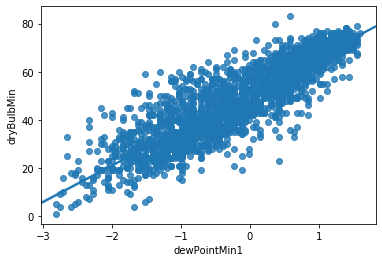

In [112]:
sns.regplot(x=X8['dewPointMin1'], y= y_train['dryBulbMin'])

X1 = X8[['dewPointMin1']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )


r squared value:   0.7374463465517629


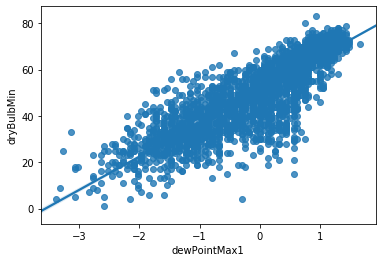

In [113]:
sns.regplot(x=X8['dewPointMax1'], y= y_train['dryBulbMin'])

X1 = X8[['dewPointMax1']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )

r squared value:   0.7887412249031892


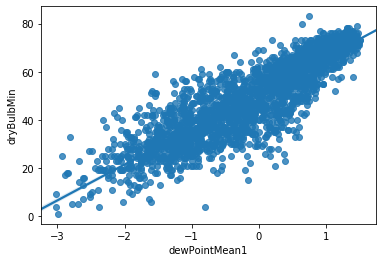

In [114]:
sns.regplot(x=X8['dewPointMean1'], y= y_train['dryBulbMin'])

X1 = X8[['dewPointMean1']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )

r squared value:   0.8175759724442072


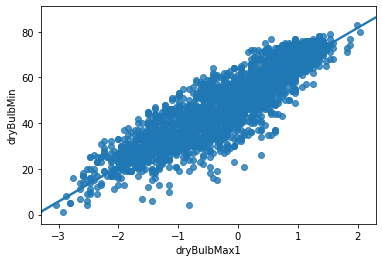

In [115]:
sns.regplot(x=X8['dryBulbMax1'], y= y_train['dryBulbMin'])


X1 = X8[['dryBulbMax1']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )

r squared value:   0.863719486422773


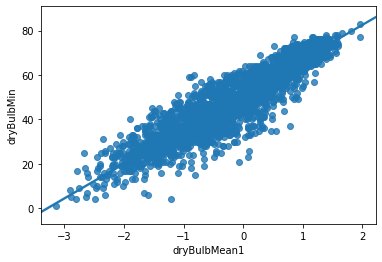

In [116]:
sns.regplot(x=X8['dryBulbMean1'], y= y_train['dryBulbMin'])

X1 = X8[['dryBulbMean1']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )

r squared value:   0.814271069885075


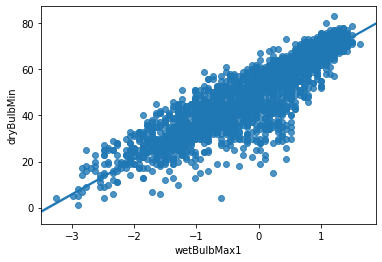

In [117]:
sns.regplot(x=X8['wetBulbMax1'], y= y_train['dryBulbMin'])

X1 = X8[['wetBulbMax1']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )

r squared value:   0.5686880584949641


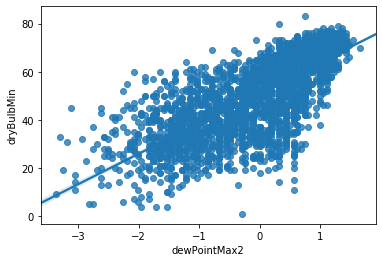

In [118]:
sns.regplot(x=X8['dewPointMax2'], y= y_train['dryBulbMin'])

X1 = X8[['dewPointMax2']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )

r squared value:   0.6230967019811186


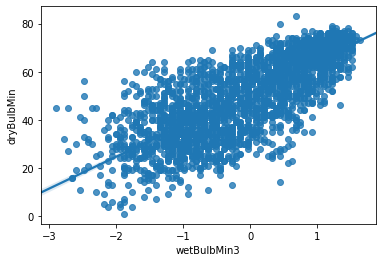

In [119]:
sns.regplot(x=X8['wetBulbMin3'], y= y_train['dryBulbMin'])

X1 = X8[['wetBulbMin3']]
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1).fit()
print("r squared value:   " + str(model.rsquared) )

### Maybe we have some multicollinearity going on here
Let's see if some of our predictors are correlated with other predictors
The linear regression model assumes that they are not...


<Figure size 504x504 with 0 Axes>

Text(0.5, 1.0, 'Correlation between the Parameters')

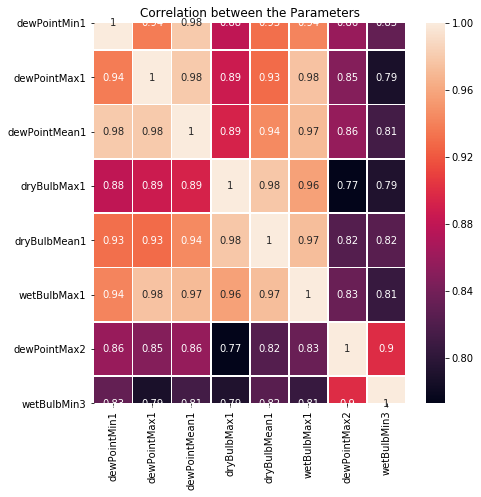

In [120]:
plt.figure(figsize=(7, 7))

plt.title('Correlation between the Parameters');

sns.heatmap(X8.drop('const',axis=1).corr(),linewidths=0.5,  annot=True)

Big time multicollinearity...

### Try some new things:
### go to a smaller model and account for multicollinearity

# Model with just 2 predictors: 

 ### Notes: 
 
 Stats model syntax: 2 different ways to do linear regression
 sm.OLS and smf.ols

There are 2 different ways to go about it 

1. sm.OLS(y,X).fit()    Note: this way you have to use X = sm.add_constant(X) to get intercept 


2. smf.ols("y~x" , data = df)



In [121]:
#these 2 parameters had the best r squared values in the individual analysis part 

X2 = X8[['dewPointMin1','dryBulbMean1']]

#note: for some reason you need () around the 2 df s that you are concatenating
smallCombined = pd.concat(  (X2, y_train) , axis=1) 
smallCombined.head(1)

dewPointMin1  dryBulbMean1  dryBulbMin
Datetime                                          
2011-06-24      1.117009      1.058779        68.0

This model is from smf and it will account for multicollinearity because it has a term where the 2
parameters are multiplied together.

In [122]:
model2 = smf.ols('dryBulbMin ~ dewPointMin1 + dryBulbMean1 + (dewPointMin1*dryBulbMean1)' , data = smallCombined).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dryBulbMin   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     6226.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:57:03   Log-Likelihood:                -8390.3
No. Observations:                2628   AIC:                         1.679e+04
Df Residuals:                    2624   BIC:                         1.681e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    50.2680      0.161    311.858      0.000      49.952      50.584
dewPointMin1                  4.4103      0.316     13.949      0.000       3.790       5.030
dryBulbMean1                 11.9137      0.320     37.188      0.000      11.286      12.542
dewPointMin1:dryBulbMean1     1.0821      0.121      8.923      0.000       0.844       1.320
==============================================================================
Omnibus:                      148.032   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              460.042
Skew:                          -0.234   Prob(JB):                    1.27e-100
Kurtosis:                       4.996   Cond. No.                         6.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Now check out the residuals and the standard error 

In [123]:
#note X2 = just the 2 parameters 

residuals = y_train['dryBulbMin'] - model2.predict(X2)
print(residuals)

Datetime
2011-06-24    -1.088077
2012-11-18    -5.836027
2015-03-26   -15.218050
2012-08-23     0.075070
2017-02-26    -5.881126
                ...    
2011-02-21     3.573525
2013-02-14    -1.712026
2016-01-26    -0.993724
2014-05-19    -2.218794
2019-04-09     2.925439
Length: 2628, dtype: float64


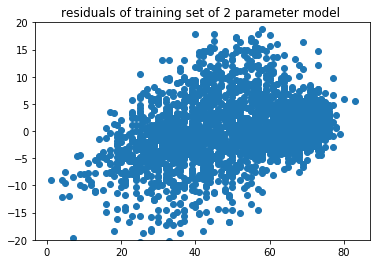

In [124]:
#residual plot

plt.scatter(y_train['dryBulbMin'], residuals)
plt.ylim(-20,20);
plt.title('residuals of training set of 2 parameter model ');

Looks a little bit to linear... It constantly overestimates hot temperatures and underestimates cold temperatures...
hmm

### Now for standard error calculation

In [125]:
SSE = sum(residuals**2)
print('SSE: ', SSE)

#MSE = SSE/ ( n - (k+1) )

MSE = (SSE)/( 2628 - (2+1))
print('MSE: ',MSE)

#S = √MSE 
S = (MSE)**(1/2)
print('root MSE: ', S)

SSE:  91257.5187587595
MSE:  34.764769050956
root MSE:  5.896165622754842


### Model with 2 predictors: 

### standard error ≈ 5.9 degrees F 

## Now use model 2 to predict the test data 

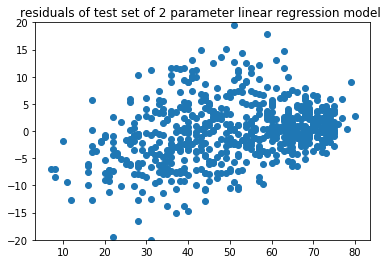

In [128]:
X_test2 = X_test[['dewPointMin1','dryBulbMean1']]

#results was the previous model name: 
ypred = model2.predict(X_test2)
residuals = y_test['dryBulbMin'] - ypred

#residual plot
plt.scatter(y_test['dryBulbMin'], residuals)
plt.ylim(-20,20);
plt.title('residuals of test set of 2 parameter linear regression model ');

In [127]:
#standard error of test set model2

SSE = sum(residuals**2)
print('SSE: ',SSE)

#MSE = SSE/ ( n - (k+1) )

MSE = (SSE)/( 657 - (2+1))
print('MSE: ',MSE)

#S = √MSE 
S = (MSE)**(1/2)
print('root MSE :',S)

SSE:  21790.09121247717
MSE:  33.318182282075185
root MSE : 5.772190423234076


### Cross Validate ...this was using the training data though, not as useful

In [129]:
sklr = LinearRegression()

crossVal10 = cross_val_score(sklr, X2, y_train, cv=10)
print("cross validation r^2 scores: ", crossVal10)
print( "average r^2 score: " , crossVal10.mean() )

cross validation r^2 scores:  [0.87942153 0.85757649 0.89080692 0.8917824  0.85403827 0.88827219
 0.86151081 0.83219533 0.90029809 0.86098918]
average r^2 score:  0.8716891221455996


### R^2 Score for test set

In [148]:
#sklr = LinearRegression()

r2_score( y_test['dryBulbMin'], model2.predict(X_test2) )

0.8784781780435155

# Non Linear Models 

In [134]:
from sklearn.ensemble import RandomForestRegressor

In [135]:
rfmodel = RandomForestRegressor(n_estimators= 100, random_state=21, min_samples_split=2)

### The following are 2 short tests to determine which predictors we are going to use for now: 

In [136]:
#fitting the random forest model to the X2 set 
rfmodel.fit(X2 , y_train['dryBulbMin'] )


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

In [137]:
r2 = rfmodel.score(X_test2, y_test)
print('R squared of regression: ',r2 )

R squared of regression:  0.8405046429512136


In [138]:
#results was the previous model name: 
predictions = rfmodel.predict(X_test2)
residuals = y_test['dryBulbMin'] - predictions

SSE = sum(residuals**2)
print('SSE: ',SSE)

#MSE = SSE/ ( n - (k+1) )

MSE = (SSE)/( 657 - (2+1))
print('MSE: ',MSE)

#S = √MSE 
S = (MSE)**(1/2)
print('RMSE :',S)

SSE:  28599.129951361116
MSE:  43.729556500552164
RMSE : 6.61283271378856


In [139]:
#fitting the random forest model to the X8 set 
rfmodel.fit(X8 , y_train['dryBulbMin'] )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

In [140]:
r2 = rfmodel.score(X_test8, y_test)
print('R squared of regression: ',r2 )

R squared of regression:  0.8795580586644184


In [141]:
#results was the previous model name: 
predictions = rfmodel.predict(X_test8)
residuals = y_test['dryBulbMin'] - predictions

SSE = sum(residuals**2)
print('SSE: ',SSE)

#MSE = SSE/ ( n - (k+1) )

MSE = (SSE)/( 657 - (2+1))
print('MSE: ',MSE)

#S = √MSE 
S = (MSE)**(1/2)
print('RMSE :',S)

SSE:  21596.457699999984
MSE:  33.02210657492353
RMSE : 5.7464864547759555


### Using about 8 predictors seems like a good amount, so we will stick with that for now
The 8 predictor model did much better than the 2 in the random forest


## These are the names of the data sets we are going to use: 
We are going to use X8 for training and X_test8 for testing 
y_train['dryBulbMin'] for training and y_test for testing 

### Try to cross validate in order to tune the parameters for the random forest model

n_estimators is the number of trees in the forest
min_samples_leaf is the minimum amount of samples that each leaf of the tree must have 

In [142]:
#This lets us use cross validation in order to check lots of parameter combinations
from sklearn.model_selection import GridSearchCV

In [143]:
# Select the optimal parameters using cross validation

tuned_parameters = [{'max_depth': [5, 10, 100] , 'min_samples_leaf':[5,10,50,100]}]
tuner = GridSearchCV(RandomForestRegressor(n_estimators=50,random_state=21), tuned_parameters, cv=10,scoring='r2')
tuner.fit(X8, y_train['dryBulbMin'])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=None,
                                             oob_score=False, random_state=21,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 100],
        

In [144]:
#extra 
#tuner.cv_results_

In [145]:
tuner.best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

Use the best parameters for the model and run cross validation to get accurate scores

In [149]:
model = RandomForestRegressor(max_depth=10,min_samples_leaf=10,n_estimators=100,random_state=21)

crossVal10 = cross_val_score(model, X_test8, y_test['dryBulbMin'], cv=10)
print("cross validation r^2 scores: ", crossVal10)
print( "average r^2 score: " , crossVal10.mean() )

cross validation r^2 scores:  [0.83200748 0.85715764 0.89454078 0.87950989 0.87835836 0.89782331
 0.85993217 0.90713975 0.86587853 0.88089751]
average r^2 score:  0.8753245430501202


### The mean r^2 score was 0.875 after cross validation

In [150]:
model.fit(X8,y_train['dryBulbMin'])
predictions = model.predict(X_test8)
residuals = y_test['dryBulbMin'] - predictions

SSE = sum(residuals**2)
print('SSE: ',SSE)

#MSE = SSE/ ( n - (k+1) )

MSE = (SSE)/( 657 - (2+1))
print('MSE: ',MSE)

#S = √MSE 
S = (MSE)**(1/2)
print('RMSE :',S)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

SSE:  21099.90330944251
MSE:  32.2628490970069
RMSE : 5.680039533049651


### R^2 for test set 

In [151]:
r2_score( y_test['dryBulbMin'], model.predict(X_test8) )

0.8823273079370643

### The RMSE was 5.68 for the Random Forest Model

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

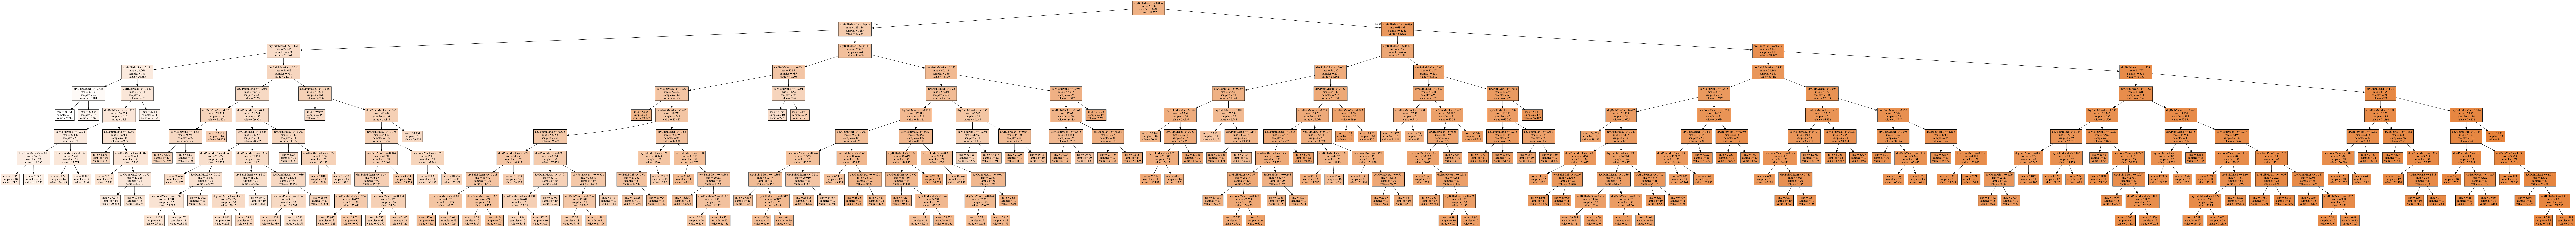

In [152]:
#These are to create a visual for the decision tree
from IPython.display import Image
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.externals.six import StringIO  
import pydot


# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)


tree1 = DecisionTreeRegressor(max_depth= 10, min_samples_leaf= 10)
tree1.fit(X8, y_train['dryBulbMin'])

graph, = print_tree(tree1, features = X8.columns)
Image(graph.create_png())

This is a picutre of one of the decision trees that might be used in the forest model. You have to zoom in to read the labels...

(-20, 20)

Text(0.5, 1.0, 'Residuals of Random Forest Model on test set ')

Text(0.5, 0, 'True Y temp')

Text(0, 0.5, 'Residual/Error')

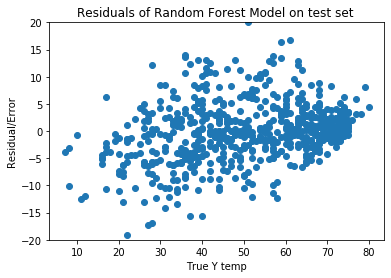

In [154]:
#residual plot
ypred = model.predict(X_test8)
residuals = y_test['dryBulbMin'] - ypred

plt.scatter(y_test['dryBulbMin'], residuals)
plt.ylim(-20,20);
plt.title('Residuals of Random Forest Model on test set ');
plt.xlabel('True Y temp')
plt.ylabel('Residual/Error')

### Random Forest Summary: r^2 was 0.875 and the RMSE = 5.68

## polynomial regression Model: Not working right now :(
The scores are the same no matter what the degree is in the model. It must not be set up right...

using degree 0-4

In [155]:

'''from sklearn.preprocessing import PolynomialFeatures
for i in range (5):
    poly_reg = PolynomialFeatures(degree=i)
    X8poly = poly_reg.fit_transform(X8)
    polymodel = LinearRegression()
    polymodel.fit(X8poly, y_train['dryBulbMin'])


    crossVal10 = cross_val_score(polymodel, X_test8, y_test['dryBulbMin'], cv=10)
    print( "average r^2 score for degree: "+str(i) , crossVal10.mean() ) '''
    


'from sklearn.preprocessing import PolynomialFeatures\nfor i in range (5):\n    poly_reg = PolynomialFeatures(degree=i)\n    X8poly = poly_reg.fit_transform(X8)\n    polymodel = LinearRegression()\n    polymodel.fit(X8poly, y_train[\'dryBulbMin\'])\n\n\n    crossVal10 = cross_val_score(polymodel, X_test8, y_test[\'dryBulbMin\'], cv=10)\n    print( "average r^2 score for degree: "+str(i) , crossVal10.mean() ) '

## Support Vector Regressor

In [156]:
from sklearn.svm import SVR

In [157]:
# Select the optimal parameters using cross validation


tuned_parameters = [{'kernel': ['rbf','poly'] , 'C':[0.001,0.01,0.1,1,10,100]}]
tuner = GridSearchCV(SVR(gamma='auto'), tuned_parameters, cv=10,scoring='r2')
tuner.fit(X8, y_train['dryBulbMin'])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf', 'poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [158]:
tuner.best_params_

{'C': 100, 'kernel': 'poly'}

In [159]:
model = SVR(gamma='auto',kernel='poly',C=100)

crossVal10 = cross_val_score(model, X_test8, y_test['dryBulbMin'], cv=10)
print("cross validation r^2 scores: ", crossVal10)
print( "average r^2 score: " , crossVal10.mean() )




cross validation r^2 scores:  [0.85327152 0.8474822  0.87157685 0.90167535 0.89281254 0.90051676
 0.89543146 0.93037896 0.87936831 0.89487897]
average r^2 score:  0.8867392911521941


In [160]:
model = SVR(gamma='auto',kernel='poly',C=100).fit(X8,y_train['dryBulbMin'])

print("This is the RMSE: ")
np.sqrt( mean_squared_error(y_test['dryBulbMin'],model.predict(X_test8)) )

This is the RMSE: 


5.456442174146756

(-20, 20)

Text(0.5, 1.0, 'Residuals of SVR Model on the test set')

Text(0.5, 0, 'True Y temp')

Text(0, 0.5, 'Residual/Error')

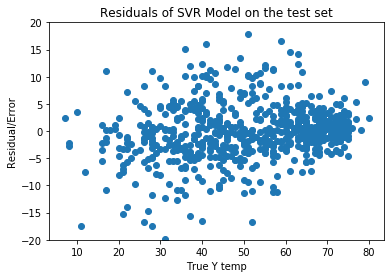

In [161]:
#residual plot
ypred = model.predict(X_test8)
residuals = y_test['dryBulbMin'] - ypred

plt.scatter(y_test['dryBulbMin'], residuals)
plt.ylim(-20,20);
plt.title('Residuals of SVR Model on the test set');
plt.xlabel('True Y temp')
plt.ylabel('Residual/Error')

### Old: We rounded out the SVR model with a 5.45 RMSE and a 0.887 r^2 value 

### R^2 using the test set

In [162]:
r2_score( y_test['dryBulbMin'], model.predict(X_test8) )

0.8909113147434664

## KNN Regressor Model

In [163]:
from sklearn.neighbors import KNeighborsRegressor

distance makes the closer neighbors have more weight than usual, and uniform uses equal weights

In [164]:
# Select the optimal parameters using cross validation
m = KNeighborsRegressor()

tuned_parameters = [{'n_neighbors': [3,5,10,20,50,100] , 'weights':['uniform','distance']}]
tuner = GridSearchCV(KNeighborsRegressor(algorithm='auto'), tuned_parameters, cv=10,scoring='r2')
tuner.fit(X8, y_train['dryBulbMin'])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 5, 10, 20, 50, 100],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [165]:
tuner.best_params_

{'n_neighbors': 20, 'weights': 'distance'}

In [166]:
knn = KNeighborsRegressor(n_neighbors=20, weights = 'distance' , algorithm='auto')
knn.fit(X8,y_train['dryBulbMin'])

crossVal10 = cross_val_score(knn, X_test8, y_test['dryBulbMin'], cv=10)
print("cross validation r^2 scores: ", crossVal10)
print( "average r^2 score: " , crossVal10.mean() )

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='distance')

cross validation r^2 scores:  [0.83000319 0.84512638 0.88907833 0.88086977 0.87533792 0.89045439
 0.88150949 0.90182745 0.87908994 0.86319211]
average r^2 score:  0.8736488977654387


In [167]:
print("This is the RMSE: ")  #we are doing square root of the mean squared error 
np.sqrt( mean_squared_error(y_test['dryBulbMin'],knn.predict(X_test8)) )

This is the RMSE: 


5.599049517082368

(-20, 20)

Text(0.5, 1.0, 'Residuals of KNN regressor model on the test set ')

Text(0.5, 0, 'True Y temp')

Text(0, 0.5, 'Residual/Error')

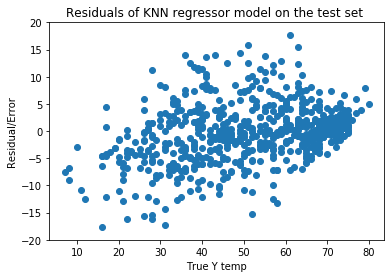

In [169]:
#results was the previous model name: 
ypred = knn.predict(X_test8)
residuals = y_test['dryBulbMin'] - ypred

#residual plot
plt.scatter(y_test['dryBulbMin'], residuals)
plt.ylim(-20,20);
plt.title('Residuals of KNN regressor model on the test set ');
plt.xlabel('True Y temp')
plt.ylabel('Residual/Error')

### Old: For KNN Regressor: Cross validated r^2 score of .874 and a RSME of 5.599

### New: R^2 value for KNN on the test same test set

In [170]:
r2_score( y_test['dryBulbMin'], knn.predict(X_test8) )

0.8851346050300826